## Meta data

In [1]:
import netCDF4 as nc4
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, ticker, rcParams
from tqdm import tqdm
import scipy.optimize as opt
import scipy.ndimage as nd
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
import matplotlib.colors as col #ListedColormap
import matplotlib.path as mpp
import h5py  # For NEW Matlab files (AMEDA)
import scipy.io as sio # For OLD Matlab files
import csv
from tools_dyned_these import MLD_threshold

rcParams['pcolor.shading']='auto'

expname='qwa_rev1w-2'  #      <============ Change run name here !

pathdir='/home6/datawork/abarboni/CROCO/TEMP_1km/HIST/'
hisdir='/home6/scratch/abarboni/QWA_HIS/'
#hisdir='/home6/datawork/abarboni/CROCO/TEMP_1km/SAVE_HIS-AVG/'

filename=hisdir+expname+'_his.nc'
avg_name=hisdir+expname+'_avg.nc'
gridname=pathdir+'aeref_grd_1km.nc'#1km_x100.nc'
#crocooutname=pathdir+'croco.out.QWA10'

path_ameda='/home6/datawork/abarboni/CROCO/RESULT/'+expname.upper()+'/'
path_ameda='/home6/datawork/abarboni/CROCO/RESULT/QWA_rev1w/'

bulk=True
timestep=2 ## time in day between time step of netcdf _avg file
rg=1 # side padding to reduce data size
depth_m=250  #39 # index of deepest RHO point
depth_surf=15
Xmax=100 # (half) window size in km
mldthres=0.1 # delta threshold =0.1 for temperature

Navg=24   ### WARNING !

str_title='Run '+expname.upper()+' - 1-week ERA5'

## Loading data

In [2]:
### Grid   ### MAKE SURE IT IS THE GOOD ONE !
f=nc4.Dataset(gridname)   
x_rho=f['x_rho'][rg:-rg,rg:-rg]/1000 ; y_rho=f['y_rho'][rg:-rg,rg:-rg]/1000
xi_rho=x_rho[0,:]
xmid=int(f.dimensions['xi_rho'].size/2)
f.close()
x_psi=(x_rho[1:,1:]+x_rho[1:,:-1]+x_rho[:-1,1:]+x_rho[:-1,:-1])/4
y_psi=(y_rho[1:,1:]+y_rho[1:,:-1]+y_rho[:-1,1:]+y_rho[:-1,:-1])/4

### Loading from AVG

In [27]:
Nt=1 # timestep selection SHOULD BE ONE HERE
### Data
f_a=nc4.Dataset(avg_name)
srho=f_a['s_rho'][:]
H0=f_a['h'][0,0] ; hc=f_a['hc'][:]
### Streching coeff
Csr=f_a['Cs_r'][:] ; sw=f_a['s_w'][:] ; Csw=f_a['Cs_w'][:] 
#######z0=hc*srho+(H0-hc)*Csr ## OLD S COORD
z0=H0*(hc*srho+H0*Csr)/(hc+H0) ## NEW S COORD
z_w= H0*(hc*sw+H0*Csw)/(hc+H0) 

ids=np.argmin(np.abs(z0+depth_surf))
idmax=np.argmin(np.abs(z0+depth_m)) 

#zeta=f_a['zeta'][::Nt,rg:-rg,rg:-rg]         #### BIG data
time=f_a['time'][::Nt]/24/3600 #time in days

temp=f_a['temp'][::Nt,idmax:,rg:-rg,rg:-rg]
#W_a=f_a['w'][::Nt,idmax:,rg:-rg,rg:-rg]## units in m/s   #*100*3600 # UNITS = cm/h

qtot=f_a['shflux'][:,rg:-rg,rg:-rg]                      ############ FLUX data
#qsen=f_a['shflx_sen'][:] ; qlat=f_a['shflx_lat'][:] ; qsw=f_a['radsw'][:] ; qlw=f_a['shflx_rlw'][:]
ustr=f_a['sustr'][:,rg:-rg,rg:-rg] ; vstr=f_a['svstr'][:,rg:-rg,rg:-rg] # in N/m^2
f_a.close()

In [30]:
zvert=z0[idmax:] ; z_dzt=z_w[idmax:]
Nx=len(xi_rho) ; Ny=len(xi_rho) ; Ns=len(time) ; Nvert=len(zvert)#numb timesteps

### Loading from HIS

In [5]:
f_h=nc4.Dataset(filename)  #[:-1] to have Ns ==Nh
f_coriolis=f_h['f'][0,0]
time_h=f_h['time'][int(Navg/2)::Navg]/24/3600#time in days
#AKv=f_h['AKt'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
temp_h=f_h['temp'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
#W_h=f_h['w'][:,idmax:,rg:-rg,rg:-rg]
#U=f_h['u'][int(Navg/2)::Navg,ids,rg:-rg,rg:-rg]
#V=f_h['v'][int(Navg/2)::Navg,ids,rg:-rg,rg:-rg]
f_h.close()
Nh=len(time_h)

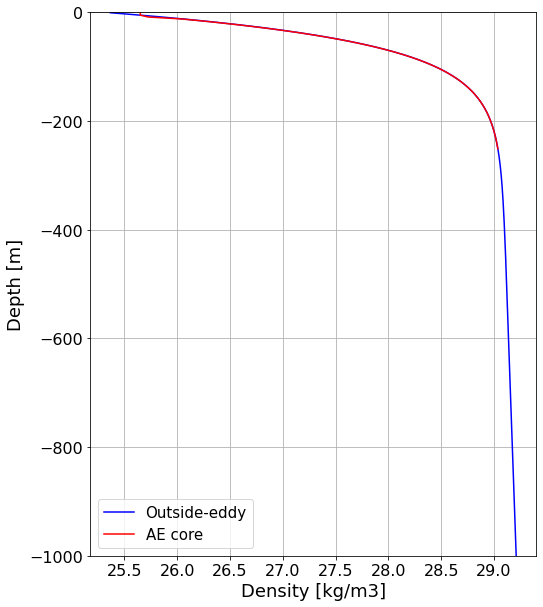

In [6]:
### Initial data
zv=np.arange(-1000,0)
#rho1=1028.95 ; rho0=1024.6 ; ZT=45 ; S=1e-4
rho1=1029.03 ; rho0=1025.3 ; ZT=55 ; S=1.8e-4
rhoini=rho1 - (rho1-rho0)*np.exp(zv/ZT) - S*zv

### Version Slope + Exp sur Temperature
#T1=14.5 ; z1=400 ; T2=17.2 ; T3=30.6 ; Zt=34
#temp_ini=T1 + (T2-T1)*(z1+zv)/z1 + (T3-T2)*np.exp(zv/Zt)
#rho_ini=1000+R0+Tcoef*(T0-temp_ini)

T0=25 ; R0=26 ; Tcoef=0.28 
rho_a=1000+R0+Tcoef*(T0-temp_h[0,:,0,0])


plt.figure(0, figsize=(8,10))
plt.plot(rhoini-1000, zv, '-b', label='Outside-eddy')
plt.plot(rho_a-1000, zvert, '-r', label='AE core') 
plt.legend(loc=3, fontsize=15) ; plt.grid() ; plt.ylim([-1000,0])
plt.xlabel('Density [kg/m3]',size=18)
plt.ylabel('Depth [m]', size=18)
plt.tick_params(labelsize=16)
#plt.savefig('/home6/datahome/abarboni/CROCO/Analysis/IniAeref7.png')

### Checking vertical resolution

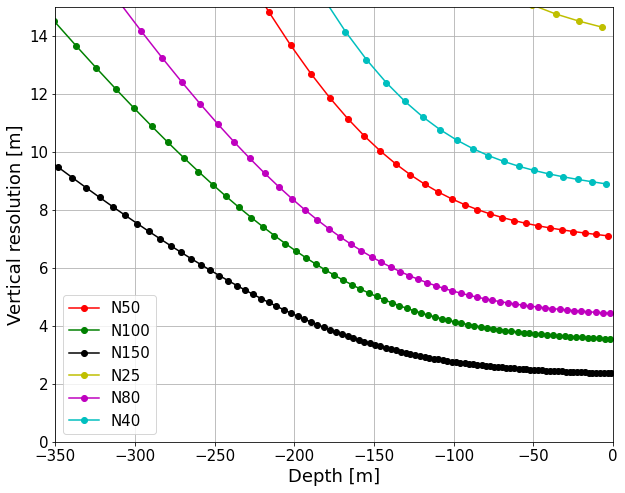

In [5]:
def zlevs(N,hc,H0,theta_s):
    srho=np.linspace(-1+1/2/N,0-1/2/N,N)
    csf=(1-np.cosh(theta_s*srho))/(np.cosh(theta_s)-1)
    Csr=csf ### because theta_b = 0
    z0=H0*(hc*srho+H0*Csr)/(hc+H0)
    return z0

plt.figure(0, figsize=(10,8))
z1=zlevs(50,400,3000,8)
z2=zlevs(100,400,3000,8)
z3=zlevs(150,400,3000,8)
z4=zlevs(25,400,3000,8)
z5=zlevs(80,400,3000,8)
z6=zlevs(40,400,3000,8)
#plt.plot(z0[1:],np.diff(z0),'-ob',label=expname.upper())# : N100, theta=8, hc=400')
plt.plot(z1[1:],np.diff(z1),'-or', label='N50')
plt.plot(z2[1:],np.diff(z2),'-og', label='N100')
plt.plot(z3[1:],np.diff(z3),'-ok', label='N150')
plt.plot(z4[1:],np.diff(z4),'-oy', label='N25')
plt.plot(z5[1:],np.diff(z5),'-om', label='N80')
plt.plot(z6[1:],np.diff(z6),'-oc', label='N40')
plt.ylim([0,15]); plt.xlim([-350,0])
plt.ylabel('Vertical resolution [m]',size=18)
plt.xlabel('Depth [m]',size=18)
plt.legend(fontsize=15) ; plt.grid() ; plt.tick_params(labelsize=15)

### Checking Heat fluxes

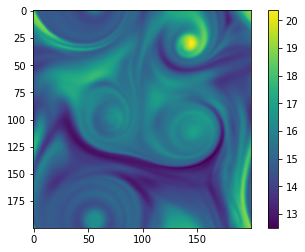

In [6]:
plt.imshow(qtot[-10]) ; plt.colorbar()
Qmean=np.mean(qtot, axis=(1,2))
Umean=np.mean(ustr,axis=(1,2)) ; Vmean=np.mean(vstr,axis=(1,2)) ; Wmean=np.sqrt(Umean**2+Vmean**2)
Wspeed=np.sqrt(Wmean/0.0016/1.2)

### Eddy wind work

In [18]:
UstrA=ustr-np.repeat(np.repeat(Umean[:,np.newaxis],200,axis=1)[:,:,np.newaxis],199,axis=2)
VstrA=vstr-np.repeat(np.repeat(Vmean[:,np.newaxis],199,axis=1)[:,:,np.newaxis],200,axis=2)

In [26]:
FeKe=(np.mean(UstrA*U[:-1],axis=(1,2))+np.mean(VstrA*V[:-1],axis=(1,2)))/1026

In [27]:
DE={}
DE['FeKe']=FeKe
np.save('../Analysis/QWA_Article_npy/FeKe_'+expname.upper()+'.npy',DE)

### Computing dynamic fields

In [9]:
dx=np.diff(x_rho, axis=1)[0,0]*1000
dy=np.diff(y_rho, axis=0)[0,0]*1000 # in meters

x_div=x_rho[1:-1,1:-1] ; y_div=y_rho[1:-1,1:-1]
#%% Vorticity
Vort=(np.diff(V,axis=2)/dx-np.diff(U,axis=1)/dy)/1e-4
#Div=(np.diff(U[:,:,1:-1],axis=1)/dx+np.diff(V[:,1:-1,:],axis=2)/dy)/1e-4/1000

NameError: name 'V' is not defined

## Loading AMEDA result (with HDF5 refs)

In [7]:
## Param_eddy_tracking
params_dict = sio.loadmat(path_ameda+'param_eddy_tracking.mat')
deg=int(params_dict['deg']) ; resol=int(params_dict['resol'])

## Grid
grid_dict = sio.loadmat(path_ameda+'gridvel_deg'+str(deg)+'_resol'+str(resol)+'.mat')
x_am=grid_dict['x'] ; y_am=grid_dict['y']
## Tracks
D = h5py.File(path_ameda+'eddy_tracks.mat','r')  ## Or tracks2.mat ??
tracks=D['tracks']
Ned=tracks['step'].shape[0]
## Syntax : 
#D[D[tracks['shapes1'][Eddy_nb,0]][0][Timestep]][Streamline, X/Y]

print('Number of timesteps :'+str(int(params_dict['stepF'])) ) ## Checking time and shape
print('Number of eddies :'+str(Ned))

Number of timesteps :277
Number of eddies :93


In [8]:
StepEddy=np.zeros((Ned, len(time)))  ## Presence matrix
Polarity=np.zeros(Ned)
for i in range(Ned):
    StepEddy[i,D[tracks['step'][i,0]][0].astype(int)-1]=1  
    ### "-1" is important because steps are counted in Matlab, in Python first index starts at 0
    Polarity[i]=np.mean(D[tracks['type'][i,0]][0].astype(int))
Color=np.zeros(Ned).astype(str)
Color[Polarity==-1]='b' ; Color[Polarity==1]='r'

In [23]:
MainEddy=np.where((np.sum(StepEddy, axis=1)>180) & (Polarity==-1))[0]
print( 'Eddy index living more than x timesteps :')
[ x for x in MainEddy.astype(str)]

#### MANUAL SELECTION
#MainEddy=np.array([0,44]) ### QWA115
#DayEddy=np.array([[0,420],[422,720]])

#MainEddy=np.array([0,168,383]) ### QWA120
#DayEddy=np.array([[0,240],[242,610],[612,720]])

#MainEddy=np.array([0,117]) ### QWA123
#DayEddy=np.array([[0,372],[374,720]])

#MainEddy=np.array([4]) ### QWA121-2

#MainEddy=np.array([15,0]) ### QWA119-3
#DayEddy=np.array([[190,240],[242,380]])

#MainEddy=np.array([43]) ### QWA201-2
#MainEddy=np.array([15]) ### QWA202-2

#MainEddy=np.array([0,158]) ### QWA119-3
#DayEddy=np.array([[0,430],[432,720]])

#MainEddy=np.array([18]) ### QWA206-2
#MainEddy=np.array([32]) ### QWA207-2
#MainEddy=np.array([17]) ### QWA208-2

#MainEddy=np.array([0,158]) ### QWA204
#DayEddy=np.array([[0,440],[442,720]])

#MainEddy=np.array([0,112]) ### QWA213
#DayEddy=np.array([[0,450],[452,720]])

#MainEddy=np.array([7]) ### QWA214

MainEddy=np.array([30]) ### QWA_rev1w

Eddy index living more than x timesteps :


### Main Eddy tracking with Day Eddy

In [10]:
Rmaxed=[] ; Vmaxed=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for ide,h in enumerate(MainEddy):
#h=167; ide=1
    steps=D[tracks['step'][h,0]][0]*timestep+time_h[0]
    ided=np.where((steps>=DayEddy[ide][0]) & (steps<=DayEddy[ide][1]))[0]

    Rmaxed+=list(D[tracks['rmax1'][h,0]][0][ided])
    Vmaxed+=list(D[tracks['velmax1'][h,0]][0][ided])
    timeeddy+=list(D[tracks['step'][h,0]][0][ided]*timestep+time_h[0])
    X1+=list(D[tracks['x1'][h,0]][0][ided]) ; Y1+=list(D[tracks['y1'][h,0]][0][ided])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

NameError: name 'DayEddy' is not defined

### Main Eddy tracking

277

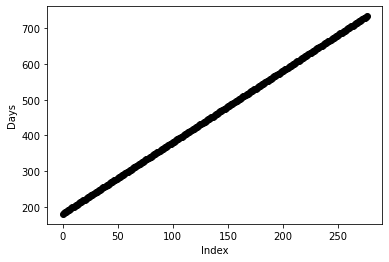

In [24]:
Rmaxed=[] ; Vmaxed=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for h in MainEddy:  ## MainEddy should contain only the eddy to be tracked !!
    Rmaxed+=list(D[tracks['rmax1'][h,0]][0])
    Vmaxed+=list(D[tracks['velmax1'][h,0]][0])
    timeeddy+=list(((D[tracks['step'][h,0]][0]-1)*timestep+time_h[0]))  ### -1 is important because in Matlab Convention !
    X1+=list(D[tracks['x1'][h,0]][0]) ; Y1+=list(D[tracks['y1'][h,0]][0])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')
Rmaxed=np.array(Rmaxed) ; Vmax=np.array(Vmaxed)
len(Rmaxed)        #     <========== Check here that Ns=len(Rmax)


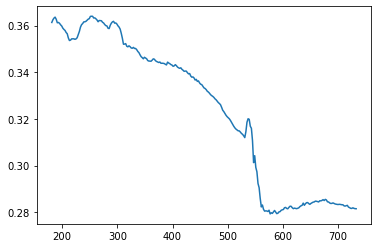

In [25]:
plt.plot(timeeddy,Vmaxed)

##  SST & Vorticity maps with AMEDA

In [12]:
SSTmax_h=np.max(temp_h[:,-1],axis=(1,2))   ### HIS version
SSTmin_h=np.min(temp_h[:,-1],axis=(1,2))
SSTmean_h=np.mean(temp_h[:,-1],axis=(1,2)) #nd.gaussian_filter1d(np.mean(temp_h[:,-1],axis=(1,2)),sigma=2)
#plt.plot(SSTmin_h) ; plt.plot(SSTmean_h)

In [13]:
cust=cm.jet ; Ncycl=10
my_cmap = cust(np.arange(cust.N))
my_cmap[:,-1] = 1-0.9*(np.sin(np.linspace(0, Ncycl*np.pi, cust.N))**10) #np.linspace(0, 1, cust.N)
my_cmap = col.ListedColormap(my_cmap)

100%|██████████| 10/10 [00:00<00:00, 194.17it/s]


Text(0.5, 0.95, 'Run QWA_REV1W-2 - 1-week ERA5 - t= 581 days')

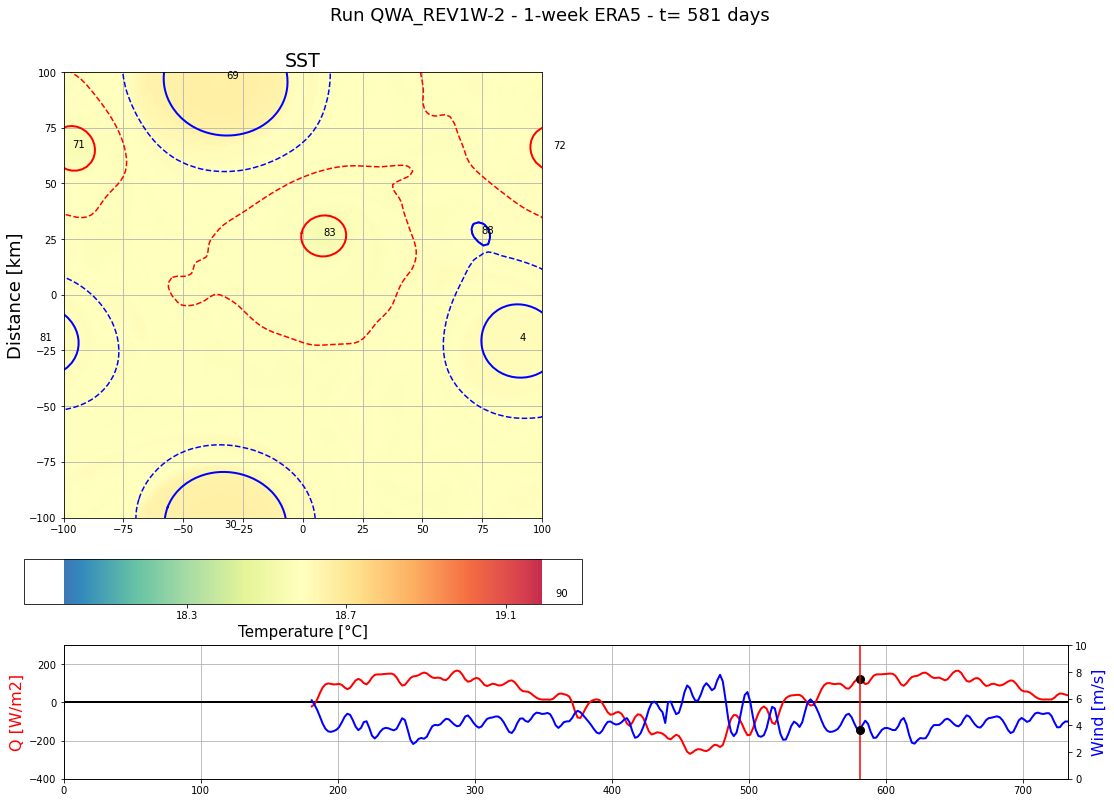

In [22]:
t=200 ; plot_number=True ; dTmax=0.6
SSTticks=np.arange(SSTmean_h[t]-2.5-(SSTmean_h[t]-dTmax)%1, SSTmean_h[t]+2-(SSTmean_h[t]-dTmax)%1,0.4)

plt.figure(0, figsize=(18,13))
gs = GridSpec(3, 2, width_ratios=[1,1], height_ratios=[10,1,3], wspace=0.1, hspace=0.2)

plt.subplot(gs[0,0])        ### SST
plt.pcolormesh(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean_h[t]-0.7, vmax=SSTmean_h[t]+0.7,cmap=cm.Spectral_r)
ListPs=np.where(StepEddy[:,t])[0]
for i in tqdm(range(len(ListPs))):  ### Plotting AMEDA eddies
    lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    if plot_number:
        plt.text(np.mean(Contour[:,0]), np.mean(Contour[:,1]), str(ListPs[i]))
    
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

plt.title('SST', size=19)  
plt.plot([0,0],[0,0],'-r', label='Cyclone') ; plt.plot([0,0],[0,0],'-b', label='Anticyclone') #; plt.legend(loc=2, fontsize=13)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() ; plt.ylabel('Distance [km]', size=18)
CB1=plt.colorbar(cax=plt.subplot(gs[1,0]), orientation='horizontal')
CB1.ax.set_xlabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=15)
CB1.ax.set_xlim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])

ax1=plt.subplot(gs[2,:])    ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
tf=np.argmin(np.abs(time-time[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8) ;plt.plot([time[tf]]*2, [-500,400],'-r')
plt.ylabel('Q [W/m2]',size=16, color='r') ; plt.ylim([-400,300])

ax2=ax1.twinx()      ### Wind
ax2.plot(time, Wspeed,'-b',lw=2) ;plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.ylabel('Wind [m/s]',size=16, color='b') ; plt.xlim([0,time[-1]]) ; plt.ylim([0,10])

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.95)

## Computing Mixed Layer Depth

In [31]:
MLDind=np.zeros((Ns, Nx, Nx))
for t in tqdm(range(len(time))):
    DT=(np.abs(temp[t,:]-temp[t,-1])<mldthres)
    MLDind[t]=np.argmin(~DT,axis=0)

100%|██████████| 277/277 [00:02<00:00, 117.91it/s]


In [32]:
MLDind_h=np.zeros((Nh, Nx,Nx))   #### HIS version
for t in tqdm(range(Nh)):
    DT=(np.abs(temp_h[t,:]-temp_h[t,-1])<mldthres)
    MLDind_h[t]=np.argmin(~DT,axis=0)

100%|██████████| 278/278 [00:02<00:00, 117.20it/s]


<ipython-input-33-cc15c1ad22e4>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_yticklabels(labels)


[Text(1, 10.0, '-181'),
 Text(1, 20.0, '-129'),
 Text(1, 30.0, '-87'),
 Text(1, 40.0, '-49'),
 Text(1, 50.0, '-12')]

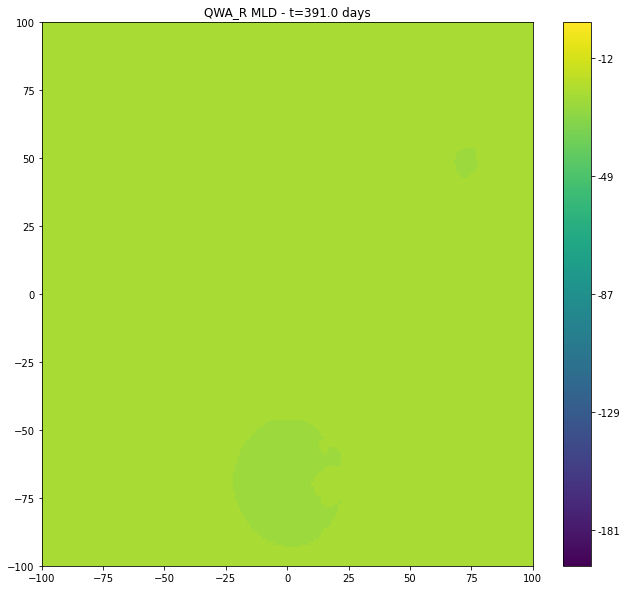

In [33]:
##### t=120  ### Check MLD
t=105
MLDmax=200
plt.figure(0,figsize=(11,10))
plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert)-1)
#ticks = [ x for x,i in enumerate(zvert.astype(int))] ; labels=[str(x) for x in zvert.astype(int)]
CB=plt.colorbar() #; CB.ax.set_yticks(ticks) ; 
#CB.ax.set_yticklabels(labels[::7])
plt.title(str_title[4:9]+ ' MLD - t='+'%3.1f'%time_h[t]+' days')
ticks=CB.get_ticks()
f = interp.interp1d(np.arange(len(zvert)), zvert)
labels=['%3.0f'%(f(x)) for x in ticks]
CB.ax.set_yticklabels(labels)

## Computing Eddy Masks

In [34]:
xlist=np.reshape(x_rho,len(x_rho)**2) ; ylist=np.reshape(y_rho,len(x_rho)**2)
#xpsilist=np.reshape(x_psi,len(x_psi)**2) ; ypsilist=np.reshape(y_psi,len(x_psi)**2)
pts=np.array([xlist,ylist]).T #; ptspsi=np.array([xpsilist,ypsilist]).T

In [35]:
MaskEnd=np.zeros((Ns, Nx,Nx))      ### mask in time_avg !
for t in tqdm(range(len(time))):
    ListPs=np.where(StepEddy[:,t])[0]
    ### Mask removing all eddies
    for i in range(len(ListPs)):
        idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]## Rmax or Rend : 'shapes1' or 'shapes3'
        Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
        path=mpp.Path(Contour, closed=True)
        Inside=np.reshape(path.contains_points(pts), np.shape(x_rho)) ; MaskEnd[t]+=Inside  

100%|██████████| 277/277 [00:40<00:00,  6.79it/s]


In [36]:
MaskMain=np.zeros((Ns, Nx, Nx)) 
#if not 'DayEddy' in locals():
#### Small trick to deal with only one eddy
DayEddy=np.array([[0,time_h[-1]]])    

for ide,h in enumerate(tqdm(MainEddy)):
#ListPs=np.where(StepEddy[:,t])[0]
## Special masks for Main Eddy
#if np.any(np.in1d(MainEddy,ListPs)):#0 in ListPs:
    steps=D[tracks['step'][h,0]][0]*timestep+time_h[0]
    ided=np.where((steps>=DayEddy[ide][0]) & (steps<=DayEddy[ide][1]))[0]
    for idbis in ided :
        Contour=D[D[tracks['shapes1'][h,0]][0][idbis]][:]
        path=mpp.Path(Contour, closed=True)
        Inside=np.reshape(path.contains_points(pts), np.shape(x_rho)) ### RHO GRID
        ## MaskMain[int(steps[idbis]/timestep)]+=Inside
        MaskMain[int((steps[idbis]-time_h[0])/timestep)-1]+=Inside   ### WARNING MODIF !

100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


In [37]:
## Mask to compute deltaT from Evangelos method
MaskRmaxIn=np.zeros((Ns,Nx,Nx)) ;  MaskRmaxOut=np.zeros((len(time), len(x_rho),len(x_rho)))
Rmin=10 # for eddy core in km
for x in tqdm(range(len(X1))):
    Dist=np.sqrt((pts[:,0]-X1[x])**2+(pts[:,1]-Y1[x])**2)
    #MaskRmaxIn[int(timeeddy[x]/timestep)]+=np.reshape(Dist<Rmax[x], np.shape(x_rho))  ### Warning MODIF
    MaskRmaxIn[int((timeeddy[x]-time_h[0])/timestep)-1]+=np.reshape(Dist<Rmin, np.shape(x_rho))
    MaskRmaxOut[int((timeeddy[x]-time_h[0])/timestep)-1]+=np.reshape((Dist<Rmaxed[x]*2.5) & (Dist>Rmaxed[x]), np.shape(x_rho))

MaskMain=MaskMain.astype(bool) ; MaskEnd=MaskEnd.astype(bool) ; 
MaskRmaxIn=MaskRmaxIn.astype(bool) ; MaskRmaxOut=MaskRmaxOut.astype(bool)

100%|██████████| 277/277 [00:00<00:00, 424.30it/s]


Text(0.5, 1.0, 'Masking Eddy perif')

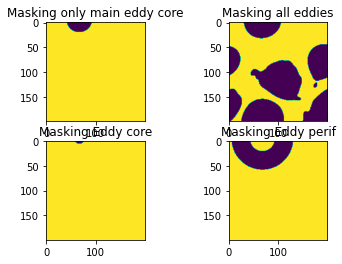

In [39]:
t=200  ## Check
plt.subplot(221) ; plt.imshow(~MaskMain[t]) ; plt.title('Masking only main eddy core')
plt.subplot(222) ; plt.imshow(~MaskEnd[t]) ; plt.title('Masking all eddies')
plt.subplot(223) ; plt.imshow(~MaskRmaxIn[t]) ; plt.title('Masking Eddy core')
plt.subplot(224) ; plt.imshow(~MaskRmaxOut[t]) ; plt.title('Masking Eddy perif')

([<matplotlib.axis.YTick at 0x2aaae0232cd0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

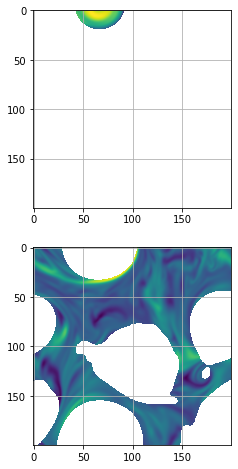

In [40]:
TempEx=np.copy(temp_h[t,-1])
TempEx[~MaskMain[t]]=np.nan
plt.figure(figsize=(5,8))
plt.subplot(211)
plt.imshow(TempEx) ; plt.grid()
plt.yticks(np.arange(0,200,50))
TempEx2=np.copy(temp_h[t,-1])
TempEx2[MaskEnd[t]]=np.nan
plt.subplot(212)
plt.imshow(TempEx2) ; plt.grid()
plt.yticks(np.arange(0,200,50))

## Computing MLD PDF

In [23]:
def pdf(Var, xar):
    N=len(xar)
    MLDx=np.zeros(N-1)
    # dx=(xar[1]-xar[0])/2
    # Xar=np.linspace(dx, 500-dx,N-1)
    Xar=xar[:-1]+np.diff(xar)/2
    for i in range(N-1):
        MLDx[i]=len(np.where((Var>xar[i]) & (Var<=xar[i+1]))[0])
    MLDx=MLDx/np.nansum(MLDx)
    return MLDx, Xar

In [47]:
MLD_h_Rmax=np.copy(MLDind_h)
for t in tqdm(range(Ns)):
    for k in range(Navg):
        MLD_h_Rmax[t*Navg+k][]

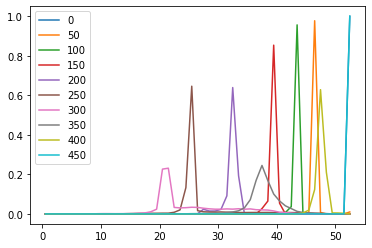

In [46]:
for t in np.arange(0,500,50):
    A,B=pdf(MLDind_h[t],np.arange(len(zvert)))
    plt.plot(B,A, label=str(t))
plt.legend()

## Extracting Eddy Temp Profiles

#### Properties at Main Eddy core

In [41]:
Nt=1  ## His time-stepping  =1 or =Navg
TempCore=np.zeros((Ns,Nvert)) ; MLDcore = np.zeros((Ns)) ; WCore=np.zeros((Ns,Nvert))
MixCore=np.zeros((Ns,Nvert+1)) ## because time_his = time_a-1day & over w grid 

f = interp.interp1d(np.arange(len(zvert)), zvert) ### Interpolation fonction
WCore_h=np.zeros((Ns*Nt,Nvert)) ;  MLDcore_h=np.zeros(Ns*Nt)
TempCore_h=np.zeros((Ns*Nt,Nvert)) ; MixCore_h=np.zeros((Ns*Nt,Nvert+1)) 

for h in MainEddy:
    for i,t in enumerate((D[tracks['step'][h,0]][0]-1).astype(int)):
        ### Data from AVG
        #TempCore[t]=temp[t,:,np.argmin(np.abs(Y1[i]-xi_rho)),np.argmin(np.abs(X1[i]-xi_rho))]
        #MLDcore[t]=f(MLDind[t,np.argmin(np.abs(Y1[i]-xi_rho)),np.argmin(np.abs(X1[i]-xi_rho))])
        #MixCore[t]=AKv[t,:,np.argmin(np.abs(Y1[i]-xi_rho)),np.argmin(np.abs(X1[i]-xi_rho))]
        #WCore[t]=W_a[t,:,np.argmin(np.abs(Y1[i]-xi_rho)),np.argmin(np.abs(X1[i]-xi_rho))]
        
        ### Data from HIS
        TempCore_h[t*Nt:(t+1)*Nt]=temp_h[t*Nt:(t+1)*Nt,:,np.argmin(np.abs(Y1[i]-xi_rho)),np.argmin(np.abs(X1[i]-xi_rho))]
        MixCore_h[t*Nt:(t+1)*Nt]=AKv[t*Nt:(t+1)*Nt,:,np.argmin(np.abs(Y1[i]-xi_rho)),np.argmin(np.abs(X1[i]-xi_rho))]
        WCore_h[t*Nt:(t+1)*Nt]=W_h[t*Nt:(t+1)*Nt,:,np.argmin(np.abs(Y1[i]-xi_rho)),np.argmin(np.abs(X1[i]-xi_rho))]
        for k in range(Nt):
            MLDcore_h[t*Nt+k]=f(MLDind_h[t*Nt+k,np.argmin(np.abs(Y1[i]-xi_rho)),np.argmin(np.abs(X1[i]-xi_rho))])
        
MLDcore[MLDcore==0]=np.nan ; MLDcore_h[MLDcore_h==0]=np.nan
TempCore[TempCore==0]=np.nan ; TempCore_h[TempCore_h==0]=np.nan

NameError: name 'AKv' is not defined

#### Properties averaged over area

In [39]:
### Data from AVG
id_dt=1 # 3 for -8m depth, 1 for -1
TempEddy=np.zeros((Ns,Nvert)) ; TempOut=np.zeros((Ns,Nvert)) ; TempCoreRmin=np.zeros((Ns,Nvert))
Qin=np.zeros(Ns) ; Qperif=np.zeros(Ns)
SSTin=np.zeros(Ns) ; SSTperif=np.zeros(Ns) ; SSTout = np.zeros(Ns)
MLDrmax=np.zeros(Ns) ; MLDout=np.zeros(Ns) ; MLDperif = np.zeros(Ns) 
MixOut=np.zeros((Ns,Nvert)) ; MixEddy=np.zeros((Ns,Nvert))
WOut=np.zeros((Ns,Nvert)) ; WEddy=np.zeros((Ns,Nvert))

### Data from HIS
TempEddy_h=np.zeros((Ns*Nt,Nvert)) ; TempOut_h=np.zeros((Ns*Nt,Nvert)) ; TempCoreRmin_h=np.zeros((Ns*Nt,Nvert))
SSTin_h=np.zeros(Ns*Nt) ; SSTperif_h=np.zeros(Ns*Nt) ; SSTout_h = np.zeros(Ns*Nt)
MLDrmax_h=np.zeros(Ns*Nt) ; MLDout_h=np.zeros(Ns*Nt) ; MLDperif_h = np.zeros(Ns*Nt) 
WEddy_h=np.zeros((Ns*Nt,Nvert)) ; WOut_h=np.zeros((Ns*Nt,Nvert))
MixOut_h=np.zeros((Ns*Nt,Nvert)) ; MixEddy_h=np.zeros((Ns*Nt,Nvert))


f = interp.interp1d(np.arange(len(zvert)), zvert) ### Interpolation fonction

for t in tqdm(range(len(time))):
    if np.any(MaskMain[t]):
        for z in range(Nvert):
            #TempEddy[t,z]=np.average(temp[t,z], weights=MaskMain[t])
            #MixEddy[t,z]=np.average(AKv[t,z+1], weights=MaskMain[t]) # so that surface value is also taken in MixEddy
            #WEddy[t,z]=np.average(W_a[t,z], weights=MaskMain[t]) 
            
            for k in range(Nt):  ### Data from HIS
                WEddy_h[t*Nt+k,z]=np.average(W_h[t*Nt+k,z], weights=MaskMain[t]) 
                TempEddy_h[t*Nt+k,z]=np.average(temp_h[t*Nt+k,z], weights=MaskMain[t])
                MixEddy_h[t*Nt+k,z]=np.average(AKv[t*Nt+k,z+1], weights=MaskMain[t])
    else:
        TempEddy[t]=np.nan ; TempEddy_h[t]=np.nan
        
#### MaskEnd
    if np.any(MaskEnd[t]):
        #WOut[t,z]=np.average(W_a[t,z], weights=~MaskEnd[t])
        #MLDout[t]=f(np.average(MLDind[t], weights=MaskEnd[t]))
        #SSTout[t]=np.average(temp[t,-1], weights=MaskEnd[t])
        #for z in range(Nvert):
            #TempOut[t,z]=np.average(temp[t,z], weights=~MaskEnd[t])
            #MixOut[t,z]=np.average(AKv[t,z+1], weights=~MaskEnd[t])  ## so that surface value is also taken in MixOut
            
        for k in range(Nt):  ### Data from HIS
            MLDout_h[t*Nt+k]=f(np.average(MLDind_h[t*Nt+k], weights=MaskEnd[t]))
            SSTout_h[t*Nt+k]=np.average(temp_h[t*Nt+k,-1], weights=MaskEnd[t])
            for z in range(Nvert):
                TempOut_h[t*Nt+k,z]=np.average(temp_h[t*Nt+k,z], weights=MaskEnd[t])
                MixOut_h[t*Nt+k,z]=np.average(AKv[t*Nt+k,z+1], weights=MaskEnd[t])
                WOut_h[t*Nt+k,z]=np.average(W_h[t*Nt+k,z], weights=MaskEnd[t])

    else:
        TempOut_h[t]=np.nan ; SSTout[t]=np.nan ; MLDout[t]=np.nan ; MLDout_h[t]=np.nan ; WOut_h[t]=np.nan
        
### Mask RmaxIn-Out
    if np.any(MaskRmaxIn[t]):
        Qin[t]=np.average(qtot[t], weights=MaskRmaxIn[t])
        Qperif[t]=np.average(qtot[t], weights=MaskRmaxOut[t])
        
        #SSTin[t]=np.average(temp[t,-1], weights=MaskRmaxIn[t])
        #SSTperif[t]=np.average(temp[t,-1], weights=MaskRmaxOut[t])
        #MLDrmax[t]=f(np.average(MLDind[t], weights=MaskRmaxIn[t]))
        #MLDperif[t]=f(np.average(MLDind[t], weights=MaskRmaxOut[t]))
        #for z in range(Nvert):
        #    TempCoreRmin[t,z]=np.average(temp[t,z], weights=MaskRmaxIn[t])
        
        for k in range(Nt):  ### Data from HIS
            MLDrmax_h[t*Nt+k]=f(np.average(MLDind_h[t*Nt+k], weights=MaskRmaxIn[t]))
            SSTin_h[t*Nt+k]=np.average(temp_h[t*Nt+k,-id_dt], weights=MaskRmaxIn[t])  ### Warning HERE
            SSTperif_h[t*Nt+k]=np.average(temp_h[t*Nt+k,-id_dt], weights=MaskRmaxOut[t])
            for z in range(Nvert):
                TempCoreRmin_h[t*Nt+k,z]=np.average(temp_h[t*Nt+k,z], weights=MaskRmaxIn[t])
        
    else:
        Qperif[t]=np.nan ; Qin[t]=np.nan
        SSTperif[t]=np.nan ; SSTin[t]=np.nan ; SSTperif_h[t]=np.nan ; SSTin_h[t]=np.nan ; 
        MLDperif[t]=np.nan ; MLDrmax[t]=np.nan ; MLDperif_h[t]=np.nan ; MLDrmax_h[t]=np.nan ;  

##### Delta SST
DeltaT=SSTin-SSTperif
DeltaT_h=SSTin_h-SSTperif_h

100%|██████████| 388/388 [00:30<00:00, 12.89it/s]


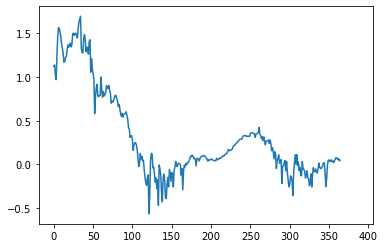

In [40]:
plt.plot(DeltaT_h)

In [41]:
#def BVF(Temp,zdiff):
T0=25 ; R0=26 ; Tcoef=0.28
N_eddy_h=np.zeros((Ns,Nvert-1))
N_out_h=np.zeros((Ns,Nvert-1))
N_core_h=np.zeros((Ns,Nvert-1))
for t in range(Ns):
    N_eddy_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempEddy_h[t]-T0))/np.diff(zvert)/1026)
    N_out_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempOut_h[t]-T0))/np.diff(zvert)/1026)
    N_core_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempCoreRmin_h[t]-T0))/np.diff(zvert)/1026)
    #N_core_h[t]= np.sqrt(-9.81 * np.gradient(R0-Tcoef*(TempCoreRmin_h[t]-T0),-np.diff(z_dzt))/1026)
#N_eddy=BVF(TempEddy) ; N_out=BVF(TempOut) ; N_core=BVF(TempCoreRmin)
#plt.plot(np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempEddy_h[t]-T0))/np.diff(zvert)/1026))
#plt.plot(np.sqrt(-9.81 * np.gradient(R0-Tcoef*(TempEddy_h[t]-T0),-np.diff(z_dzt))/1026))
zs=(zvert[1:]+zvert[:-1])/2

<ipython-input-41-ff731db28b2c>:7: RuntimeWarning: invalid value encountered in sqrt
  N_eddy_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempEddy_h[t]-T0))/np.diff(zvert)/1026)
<ipython-input-41-ff731db28b2c>:8: RuntimeWarning: invalid value encountered in sqrt
  N_out_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempOut_h[t]-T0))/np.diff(zvert)/1026)
<ipython-input-41-ff731db28b2c>:9: RuntimeWarning: invalid value encountered in sqrt
  N_core_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempCoreRmin_h[t]-T0))/np.diff(zvert)/1026)


### Checking profiles

Text(0, 0.5, 'Depth [m]')

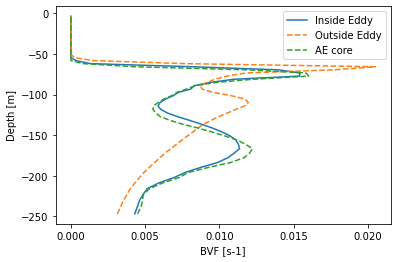

In [46]:
t=230     ##### BVF
plt.plot(N_eddy_h[t],zs,'-', label='Inside Eddy')
plt.plot(N_out_h[t],zs,'--', label='Outside Eddy')
plt.plot(N_core_h[t],zs,'--', label='AE core')
#plt.xlim([0,0.3]) ;plt.grid()
plt.legend() ; plt.xlabel('BVF [s-1]') ; plt.ylabel('Depth [m]')

Text(0.5, 1.0, 'AKv - t=105')

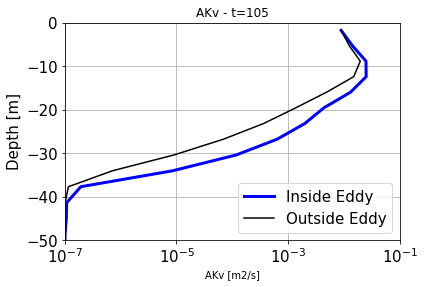

In [43]:
t=105       ######## Mixing
plt.plot(MixEddy_h[t],zvert,'-b', lw=3, label='Inside Eddy')
plt.plot(MixOut_h[t],zvert,'-k', label='Outside Eddy')
#plt.plot(MixCore_h[t],z_dzt,'--', label='AE core')
plt.xscale('log') ;plt.ylim([-50,0]) ;plt.xlim([1e-7,1e-1])
plt.tick_params(labelsize=15) ; plt.grid()
plt.legend(loc=4,fontsize=15) ; plt.xlabel('AKv [m2/s]') ; plt.ylabel('Depth [m]',size=15)
plt.title('AKv - t='+str(t))

(-250.0, 0.0)

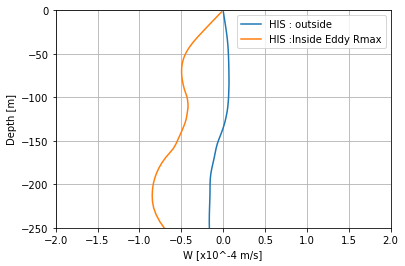

In [44]:
t=140      ### vertical speed
plt.plot(WOut_h[t]*1e4,zvert,'-', label='HIS : outside')
plt.plot(WEddy_h[t]*1e4,zvert,'-', label='HIS :Inside Eddy Rmax')
#plt.plot(WOut[t],zvert,'--', label='Outside Eddy')
plt.grid() ; plt.xlim([-2,2])
plt.legend() ; plt.xlabel('W [x10^-4 m/s]') ; plt.ylabel('Depth [m]') ; plt.ylim([-250,0])

## FFT analysis

Text(0.5, 0, 'Time [days]')

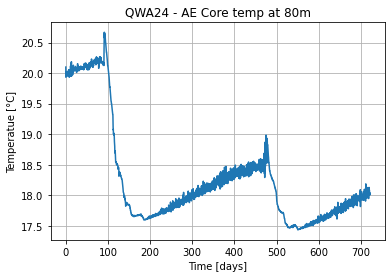

In [45]:
depth=80
plt.plot(time_h,TempCore_h[:,np.argmin(np.abs(zvert+depth))])
plt.title(str_title[4:9]+' - AE Core temp at '+str(depth)+'m') ; plt.grid()
plt.ylabel('Temperatue [\N{DEGREE SIGN}C]')
plt.xlabel('Time [days]')

In [162]:
np.shape(temp)

(361, 54, 200, 200)

Text(0.5, 1.0, 'QWA25 - AE Core temp spectrum at 20m')

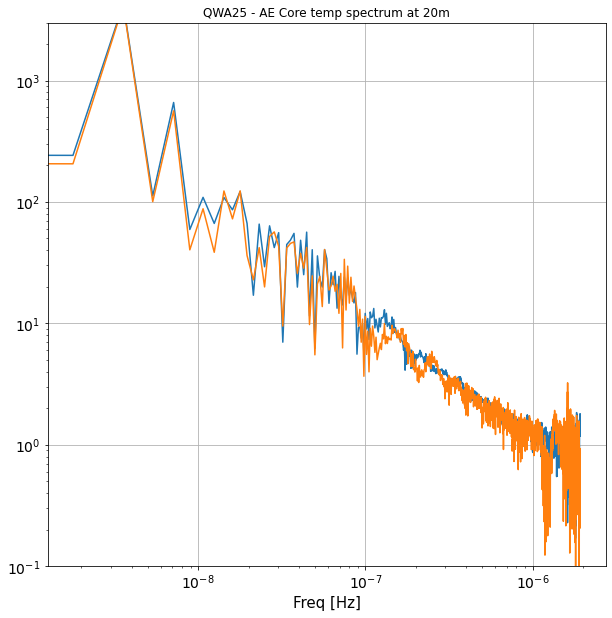

In [23]:
depth=20 ; his_per_day=int(Navg/2)
FT=np.fft.rfft(TempCore_h[:,np.argmin(np.abs(zvert+depth))])
FT2=np.fft.rfft(temp_h[:,np.argmin(np.abs(zvert+depth)),0,0])
freq_h=np.fft.rfftfreq(len(time_h),86400*his_per_day)

plt.figure(0, figsize=(10,10))
plt.plot(freq_h,np.abs(FT2))
plt.plot(freq_h,np.abs(FT))
plt.yscale('log') ; plt.xscale('log') ; plt.grid()
plt.ylim([0.1,3e3]) ; plt.tick_params(labelsize=14)
plt.xlabel('Freq [Hz]',size=15)
plt.title(str_title[4:9]+' - AE Core temp spectrum at '+str(depth)+'m')

/home6/datahome/abarboni/.conda/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


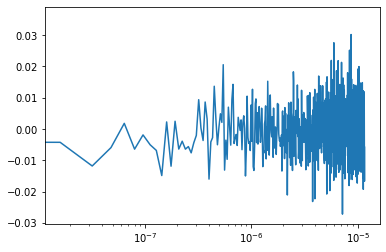

In [98]:
depth=150
FW=np.fft.rfft(WCore_h[:,np.argmin(np.abs(zvert+depth))])
freq_h=np.fft.rfftfreq(len(time_h),86400*his_per_day)
plt.plot(freq_h,FW) #; plt.ylim(-100,400)
plt.xscale('log')

## Plot with SST & profiles

In [34]:
path_save='../Analysis/QWA22/'

In [ ]:
t=50 ; LS=15 ; TS=14
#for t in tqdm(range(10,len(time))):
SSTticks=np.arange(SSTmean[t]-1.5-(SSTmean[t]-0.5)%1, SSTmean[t]+1.5-(SSTmean[t]-0.5)%1,0.2)

plt.figure(0, figsize=(15,15))
gs = GridSpec(2, 2, width_ratios=[2,2], height_ratios=[3,8], wspace=0.1, hspace=0.2)

### SST
plt.subplot(gs[1,0])
plt.pcolor(xi_rho,xi_rho,temp[t,-1,:,:],vmin=SSTmean[t]-0.5, vmax=SSTmean[t]+0.5,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)

### Plotting AMEDA eddies
ListPs=np.where(StepEddy[:,t])[0]
for i in range(len(ListPs)):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

plt.title('SST', size=18)  
plt.plot([0,0],[0,0],'-r', label='Cyclone') ; plt.plot([0,0],[0,0],'-b', label='Anticyclone')
plt.legend(loc=2, fontsize=13) ; plt.tick_params(labelsize=TS)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() ; plt.ylabel('Distance [km]', size=LS)
CB1=plt.colorbar(orientation='horizontal')#, cax=plt.subplot(gs[2,:2]), )
CB1.ax.set_xlabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=LS)
CB1.ax.set_xlim([SSTmean[t]-0.5,SSTmean[t]+0.5])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(labelsize=TS)

ax0= plt.subplot(gs[1,1]) ; plt.grid()                      ### Temp Profiles
plt.plot(TempEddy[t],zvert,'-b',lw=2, label='Inside Eddy')
plt.plot(TempOut[t],zvert,'-k',lw=2, label='Outside Eddy')
plt.plot(TempCoreRmin[t],zvert,'-c',lw=2, label='AE core')
plt.legend(fontsize=TS) ; plt.xlabel('Temp [\N{DEGREE SIGN}C]',size=LS) ; plt.ylabel('Depth [m]',size=LS)
ax0.yaxis.set_label_position("right")
plt.tick_params(labelsize=15,left=False, right=True, labelleft=False, labelright=True)  ; plt.ylim([-250,0])

ax1=ax0.twiny()                                   ### AKv profiles
plt.plot(MixEddy[t],zvert,'--b',lw=2)
plt.plot(MixOut[t],zvert,'--k', lw=2)
plt.plot(MixCore[t],z_dzt,'--c', lw=2)
plt.xscale('log') ;plt.xlim([1e-6,3e-1])
plt.xlabel('AKv [m2/s]', size=LS) ;plt.tick_params(labelsize=TS)

ax2= plt.subplot(gs[0,:])                            ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid()
plt.xlabel('Time [days]',size=LS)
plt.plot(time[t], Qmean[t],'ok', ms=8) ; plt.plot([time[t]]*2, [-400,300],'-r')
plt.ylabel('Q [W/m2]',size=LS,color='r') ; plt.tick_params(labelsize=TS)
plt.xlim([0,time[-1]]) ; plt.ylim([-400,300])

ax3=ax2.twinx() ; plt.tick_params(labelsize=TS)     #### Wind  
plt.plot(time, Wspeed,'-b') ; plt.plot(time[t], Wspeed[t],'ok', ms=8)
plt.ylabel('Wind [m/s]',size=LS, color='b')

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.91)

    ####
    #plt.tight_layout()
    #plt.savefig(path_save+'SST_prof_t='+'{:03.0f}'.format(time[t])+'.png')
    #plt.close()

### Movie

In [35]:
moviename='QWA21_SST_MLD'
path_save='../Analysis/QWA21_MLD/'
path_save

'../Analysis/QWA21_MLD/'

In [36]:
import imageio
import os
kargs = { 'macro_block_size': None }#, 'ffmpeg_params': [ '-r', '12']}

filelist=os.listdir(path_save)
filelist=np.sort(filelist)
if filelist[0]=='.ipynb_checkpoints':
    filelist=filelist[1:] #to remove '.ipynb_checkpoints'
images = []

for k in tqdm(range(len(filelist))):
    filename=path_save+filelist[k]  ###   <========== CHANGE FILENAME HERE #######
    images.append(imageio.imread(filename))
   
imageio.mimwrite(path_save+'../Movies/'+moviename+'.mp4', images, 'MP4', fps=2)#**kargs)   ####  <===== Change movie.mp4 name here

100%|██████████| 949/949 [00:46<00:00, 20.20it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1296, 936) to (1296, 944) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Timeseries SST-MLD-Q (AVG)

Text(0.5, 0.92, 'Run QWA30 - Q+W sensibility - NoBulk')

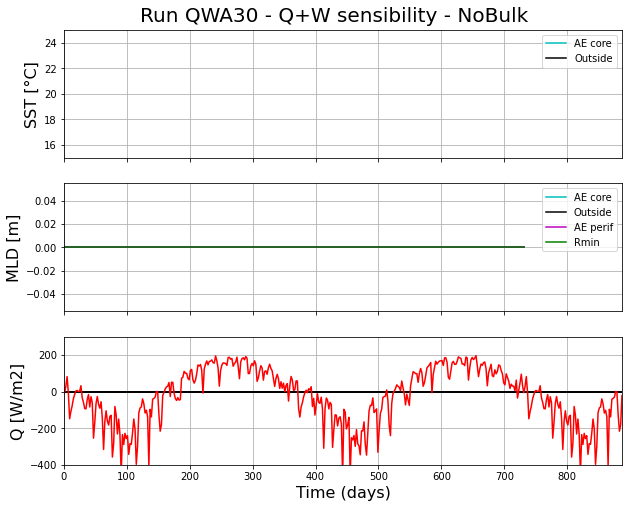

In [155]:
plt.figure(0, figsize=(10,8))
plt.subplot(311) ; plt.grid()
plt.plot(time, SSTin,'-c',label='AE core')
plt.plot(time, SSTout,'-k',label='Outside')
plt.legend() ; plt.xlim([0,time[-1]]) ; plt.ylim([15,25])
plt.tick_params(labelbottom=False)
plt.ylabel('SST [\N{DEGREE SIGN}C]', size=16)

plt.subplot(312) ; plt.grid()
plt.plot(time, MLDcore, '-c', label='AE core') ; plt.plot(time, MLDout, '-k', label='Outside')
plt.plot(time, MLDperif, '-m', label='AE perif') ; plt.plot(time, MLDrmax, '-g', label='Rmin')
plt.ylabel('MLD [m]', size=16) ; plt.legend() ; plt.xlim([0,time[-1]])  ; plt.tick_params(labelbottom=False)

plt.subplot(313)
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid()
plt.ylabel('Q [W/m2]',size=16) ;plt.xlim([0,time[-1]]) ; plt.ylim([-400,300])
plt.xlabel('Time (days)', size=16)

path_save='../Analysis/'
plt.suptitle(str_title, y=0.92,size=20)
#plt.savefig(path_save+'QWA19_SST_MLD_evol.png')

## Timeseries SST-MLD-Q (HIS)

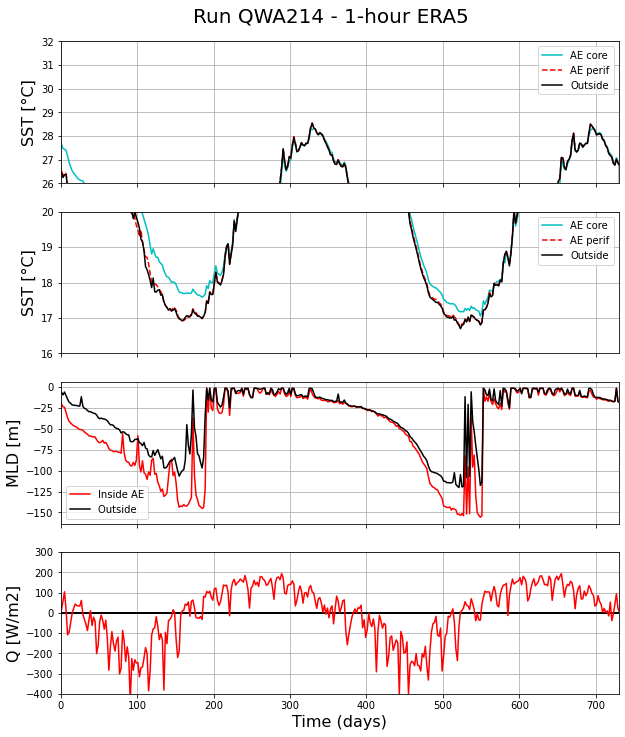

In [48]:
plt.figure(0, figsize=(10,12))

plt.subplot(411) ; plt.grid()
plt.plot(time, SSTin_h,'-c',label='AE core')
plt.plot(time, SSTperif_h,'--r',label='AE perif')
plt.plot(time, SSTout_h,'-k',label='Outside')
plt.legend() ; plt.xlim([0,730]) ; plt.ylim([26,32])
plt.tick_params(labelbottom=False)
plt.ylabel('SST [\N{DEGREE SIGN}C]', size=16)

plt.subplot(412) ; plt.grid()
plt.plot(time, SSTin_h,'-c',label='AE core')
plt.plot(time, SSTperif_h,'--r',label='AE perif')
plt.plot(time, SSTout_h,'-k',label='Outside')
plt.legend() ; plt.xlim([0,730]) ; plt.ylim([16,20])
plt.tick_params(labelbottom=False)
plt.ylabel('SST [\N{DEGREE SIGN}C]', size=16)

plt.subplot(413) ; plt.grid()
#plt.plot(time, nd.gaussian_filter1d(MLDrmax_h,sigma=2), '-r', label='Inside AE')
#plt.plot(time, nd.gaussian_filter1d(MLDout_h,sigma=2), '-k', label='Outside ')
plt.plot(time, MLDrmax_h, '-r', label='Inside AE')
plt.plot(time, MLDout_h, '-k', label='Outside ')
plt.ylabel('MLD [m]', size=16)
plt.legend() ; plt.xlim([0,730])  ; plt.tick_params(labelbottom=False)

plt.subplot(414)
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid()
plt.ylabel('Q [W/m2]',size=16)
plt.xlim([0,730]) ; plt.ylim([-400,300])
plt.xlabel('Time (days)', size=16)

path_save='../Analysis/'
plt.suptitle(str_title, y=0.92,size=20)
plt.savefig(path_save+expname.upper()+'_SST_MLD_evol.png')

## Hovmuller with AVG data

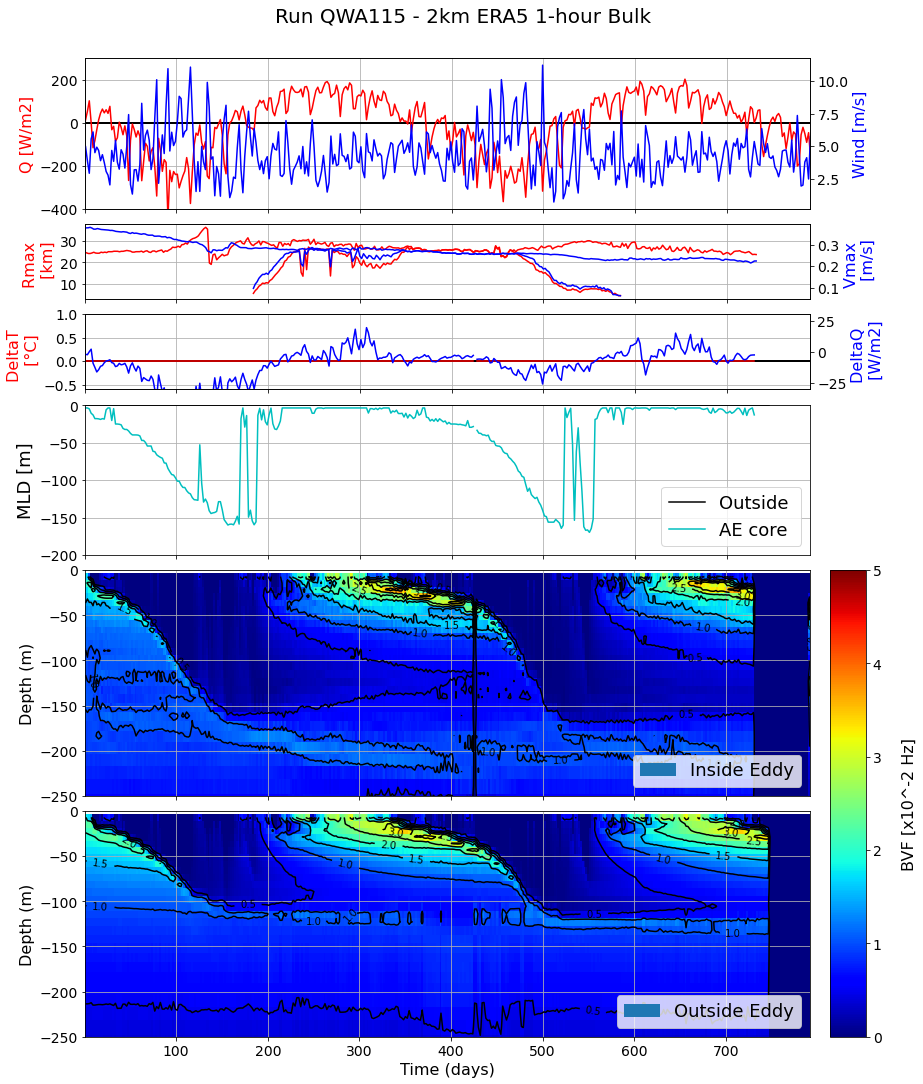

In [53]:
plt.figure(0, figsize=(14,18)) ; LS=14
gs = GridSpec(6, 2, width_ratios=[20,1], height_ratios=[2,1,1,2,3,3], wspace=0.05, hspace=0.1)

ax0= plt.subplot(gs[1,0])                                  ###### RMAX
for h in MainEddy:
    plt.plot(D[tracks['step'][h,0]][0]*timestep, D[tracks['rmax1'][h,0]][0],'-r')
plt.grid() ; plt.ylabel('Rmax \n [km]', size=16, color='r') ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.xlim([0,time[-1]])
ax1=ax0.twinx(); plt.tick_params(labelbottom=False, labelsize=LS)  ###### VMAX
for h in MainEddy:
    ax1.plot(D[tracks['step'][h,0]][0]*timestep, D[tracks['velmax1'][h,0]][0],'-b')
plt.ylabel('Vmax \n [m/s]', size=16, color='b')
          
ax2 = plt.subplot(gs[0,0])                             ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('Q [W/m2]',size=16, color='r') ; plt.xlim([0,time[-1]]) ; plt.ylim([-400,300])

ax3=ax2.twinx() ; plt.tick_params(labelsize=LS)     #### Wind  
plt.plot(time, Wspeed,'-b') 
plt.ylabel('Wind [m/s]',size=16, color='b')

ax4 = plt.subplot(gs[2,0])                             ### DeltaSST
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, SSTin-SSTperif,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('DeltaT \n [\N{DEGREE SIGN}C]',size=16,color='r')
plt.yticks(np.arange(-0.5,1.5,0.5))
plt.xlim([0,time[-1]]) ; plt.ylim([-0.6,1])

ax5=ax4.twinx() ; plt.tick_params(labelsize=LS)    ##### Delta Q
plt.plot(time, Qin-Qmean,'-b') 
plt.ylim([-30,30])
plt.ylabel('DeltaQ \n [W/m2]', size=16, color='b')

plt.subplot(gs[3,0])                                            ### MLD [t]
plt.plot(time, MLDout, '-k', label='Outside ') ; plt.plot(time, MLDrmax_h, '-c', label='AE core')
plt.xlim([0,time[-1]]) ; plt.ylim([-200,1]) ; plt.grid() ; plt.legend(fontsize=18)
plt.ylabel('MLD [m]', size=18) ; plt.tick_params(labelbottom=False, labelsize=LS)

plt.subplot(gs[4,0])                                        #### BVF inside
CP1 = plt.pcolor(time, zs, N_core_h.T*1e2,cmap=cm.jet,vmin=0, vmax=5); plt.grid()
CP2 = plt.contour(time, zs, N_core_h.T*1e2,colors=['k'],levels=np.arange(0.5,4,0.5))
plt.clabel(CP2, fmt='%1.1f')
plt.ylabel('Depth (m)',size=16)  ; plt.legend(['Inside Eddy'], loc=4, fontsize=18)
plt.ylim([-250,0])  ; plt.tick_params(labelbottom=False, labelsize=LS)
CB=plt.colorbar(CP1,cax=plt.subplot(gs[4:,1]))
CB.ax.set_ylabel('BVF [x10^-2 Hz]', fontsize=16, labelpad=20)
CB.ax.tick_params(labelsize=LS)

plt.subplot(gs[5,0])                                       #### BVF Outside
CP1 = plt.pcolor(time, zs, N_out_h.T*1e2,cmap=cm.jet,vmin=0, vmax=5); plt.grid()
CP2 = plt.contour(time, zs, N_out_h.T*1e2,colors=['k'], levels=np.arange(0.5,4,0.5))
plt.clabel(CP2, fmt='%1.1f')
plt.ylabel('Depth (m)',size=16) ; plt.legend(['Outside Eddy'], loc=4, fontsize=18)
plt.xlabel('Time (days)', size=16) ; plt.ylim([-250,0]) ; plt.tick_params( labelsize=LS)

plt.suptitle(str_title, y=0.92,size=20)

path_save='../Analysis/'
#plt.savefig(path_save+str_title[4:9]+'_N2_deltaT_evol.png')

## Hovmuller with HIS data

In [49]:
Levels=list(np.arange(0.001,0.01,0.001))+list(np.arange(0.01,0.02,0.005))
#Levels

<ipython-input-50-fc1a251b1e3a>:52: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(time,nd.gaussian_filter1d(np.average(MixEddy_h[:,id20:]/MixOut_h[:,id20:],axis=1),sigma=1), '-k', lw=2, label='Surface to 20m')
<ipython-input-50-fc1a251b1e3a>:53: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(time,nd.gaussian_filter1d(np.average(MixEddy_h[:,id50:]/MixOut_h[:,id50:],axis=1),sigma=1), '--k', lw=2, label='Surface to 50m')


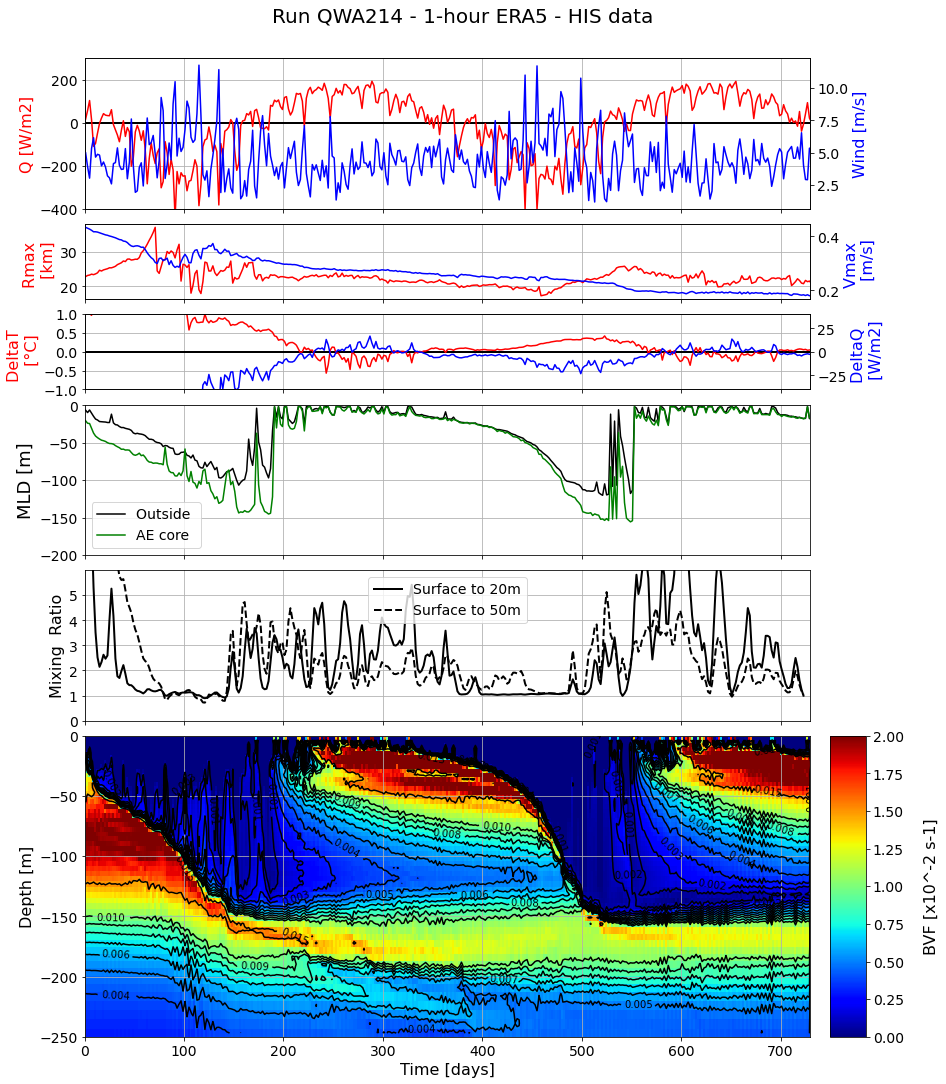

In [50]:
plt.figure(0, figsize=(14,18)) ; LS=14 ; dTmax=1
id20 =np.argmin(np.abs(zvert+20)) ; id50 =np.argmin(np.abs(zvert+50))

gs = GridSpec(6, 2, width_ratios=[20,1], height_ratios=[2,1,1,2,2,4], wspace=0.05, hspace=0.1)

ax0= plt.subplot(gs[1,0])                                  ###### RMAX
plt.plot(timeeddy,Rmaxed,'-r')
#for h in MainEddy:
#    plt.plot(D[tracks['step'][h,0]][0]*timestep, D[tracks['rmax1'][h,0]][0],'-r')
plt.grid() ; plt.ylabel('Rmax \n [km]', size=16, color='r') ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.xlim([0,2*365])
          
ax1=ax0.twinx(); plt.tick_params(labelbottom=False, labelsize=LS)  ###### VMAX
plt.plot(timeeddy,Vmaxed,'-b')
#for h in MainEddy:
#    ax1.plot(D[tracks['step'][h,0]][0]*timestep, D[tracks['velmax1'][h,0]][0],'-b')
plt.ylabel('Vmax \n [m/s]', size=16, color='b')
          
ax2 = plt.subplot(gs[0,0])                                     ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('Q [W/m2]',size=16, color='r')
plt.xlim([0,2*365]) ; plt.ylim([-400,300])

ax3=ax2.twinx() ; plt.tick_params(labelsize=LS)     #### Wind  
plt.plot(time, Wspeed,'-b') 
plt.ylabel('Wind [m/s]',size=16, color='b')

ax4 = plt.subplot(gs[2,0])                                      ### DeltaSST
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, DeltaT_h,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('DeltaT \n [\N{DEGREE SIGN}C]',size=16,color='r')
plt.yticks(np.arange(-2,3,0.5))
plt.xlim([0,2*365]) ; plt.ylim([-dTmax,dTmax])

ax5=ax4.twinx() ; plt.tick_params(labelsize=LS)    ##### Delta Q
plt.plot(time, Qin-Qmean,'-b') 
plt.ylim([-40,40])
plt.ylabel('DeltaQ \n [W/m2]', size=16, color='b')

plt.subplot(gs[3,0])                                            ### MLD [t]
#plt.plot(time_h, nd.gaussian_filter1d(MLDout_h,sigma=1), '-k', label='Outside ')
#plt.plot(time_h, nd.gaussian_filter1d(MLDcore_h,sigma=1), '-c', label='AE core')
plt.plot(time, MLDout_h, '-k', label='Outside ')
#plt.plot(time, MLDcore_h, '-g', label='AE core')
plt.plot(time, MLDrmax_h, '-g', label='AE core')
plt.xlim([0,2*365]) ; plt.ylim([-200,1]) ; plt.grid()
plt.ylabel('MLD [m]', size=18) ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.legend(fontsize=LS)

plt.subplot(gs[4,0])                                        #### Mixing Ratio
plt.plot(time,nd.gaussian_filter1d(np.average(MixEddy_h[:,id20:]/MixOut_h[:,id20:],axis=1),sigma=1), '-k', lw=2, label='Surface to 20m')
plt.plot(time,nd.gaussian_filter1d(np.average(MixEddy_h[:,id50:]/MixOut_h[:,id50:],axis=1),sigma=1), '--k', lw=2, label='Surface to 50m')
plt.legend(fontsize=LS) ; plt.ylim([0,6]) ; plt.xlim([0,2*365])  ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.yticks(np.arange(0,6))
plt.ylabel('Mixing  Ratio',size=16) ; plt.grid()

plt.subplot(gs[5,0])                                        #### BVF inside
CP1 = plt.pcolor(time, zs, N_core_h.T*100,cmap=cm.jet,vmin=0, vmax=2); plt.grid()
CP2 = plt.contour(time, zs, N_core_h.T,colors=['k'],levels=Levels)
plt.clabel(CP2, fmt='%1.3f')  ; plt.xlim([0,2*365])
plt.ylabel('Depth [m]',size=16)  #; plt.legend(['Inside Eddy'], loc=4, fontsize=18)
plt.ylim([-250,0])  ; plt.tick_params(labelsize=LS) ;  plt.xlabel('Time [days]', size=16) 
CB=plt.colorbar(CP1,cax=plt.subplot(gs[5,1]))
CB.ax.set_ylabel('BVF [x10^-2 s-1]', fontsize=16, labelpad=20)
CB.ax.tick_params(labelsize=LS)

plt.suptitle(str_title+' - HIS data', y=0.92,size=20)

path_save='../Analysis/'
plt.savefig(path_save+expname.upper()+'_HIS_N2_deltaT_evol.png')

## Computing Thermal Feedback

In [55]:
def linear(x,a):
    return a*x
DeltaQ=Qin-Qmean

In [56]:
DeltaT=DeltaT_h[::Nt]  ### WARNING Check this !! To have DeltaT at same timesteps than DeltaQ

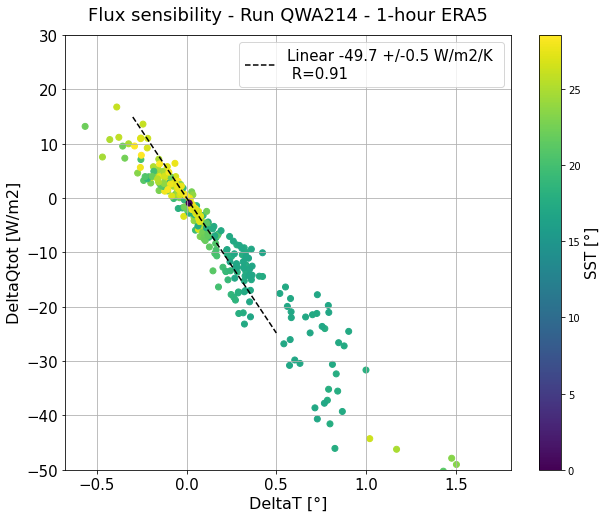

In [57]:
plt.figure(0, figsize=(10,8))

plt.scatter(DeltaT,DeltaQ, c=SSTout_h[::Nt])


DeltaQa=DeltaQ[~np.isnan(DeltaQ)] ; DeltaTa=DeltaT[~np.isnan(DeltaQ)]
R=np.cov(DeltaQa,DeltaTa)[0,1]**2/np.std(DeltaQa)**2/np.std(DeltaTa)**2
A0,S=opt.curve_fit(linear,DeltaTa,DeltaQa,[0])
plt.plot(np.arange(-0.3,0.6,0.1),linear(np.arange(-0.3,0.6,0.1),A0),'--k', label='Linear '+'%3.1f'%A0+' +/-'+'%2.1f'%S+' W/m2/K \n R='+'%0.2f'%R)

plt.grid() ; CB = plt.colorbar()
CB.set_label('SST [\N{DEGREE SIGN}]', size=15)
plt.xlabel('DeltaT [\N{DEGREE SIGN}]', size=16)
plt.ylabel('DeltaQtot [W/m2]', size=16)
plt.ylim([-50,30])
plt.tick_params(labelsize=15) ;plt.legend(fontsize=15)
plt.title('Flux sensibility - '+str_title,size=18, y=1.02)

plt.savefig(path_save+expname.upper()+'_THFF.png')


## Saving Eddy timeseries

In [58]:
DE={}
h=MainEddy[0]      ### WARNING : ASSUMES ONLY ONE MAINEDDY !
DE['timeeddy']=timeeddy
DE['Rmax']=Rmaxed
DE['Vmax']=Vmaxed
DE['time_a']=time
DE['time_h']=time_h
DE['Qin']=Qin
DE['Qmean']=Qmean
DE['Wspeed']=Wspeed
DE['SSTin_h']=SSTin_h
DE['SSTperif_h']=SSTperif_h
DE['SSTout_h']=SSTout_h
DE['MLDout_h']=MLDout_h
DE['MLDcore_h']=MLDcore_h
DE['MLDrmax_h']=MLDrmax_h

### 2D var
DE['WOut_h']=WOut_h
DE['WEddy_h']=WEddy_h
DE['TempEddy_h']=TempEddy_h
DE['TempCoreRmin_h']=TempCoreRmin_h
DE['TempOut_h']=TempOut_h
DE['zvert']=zvert
#DE['MixCore_h']=MixCore_h
DE['MixEddy_h']=MixEddy_h
DE['MixOut_h']=MixOut_h
DE['z_dzt']=z_dzt
np.save('../Analysis/DictEddy_HIS_'+expname.upper()+'.npy',DE)

<ipython-input-55-81398b1a4552>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  CP1 = plt.pcolor(time_h, zvert, WEddy_h.T*1e4,cmap=cm.seismic,vmin=-5, vmax=5); plt.grid()


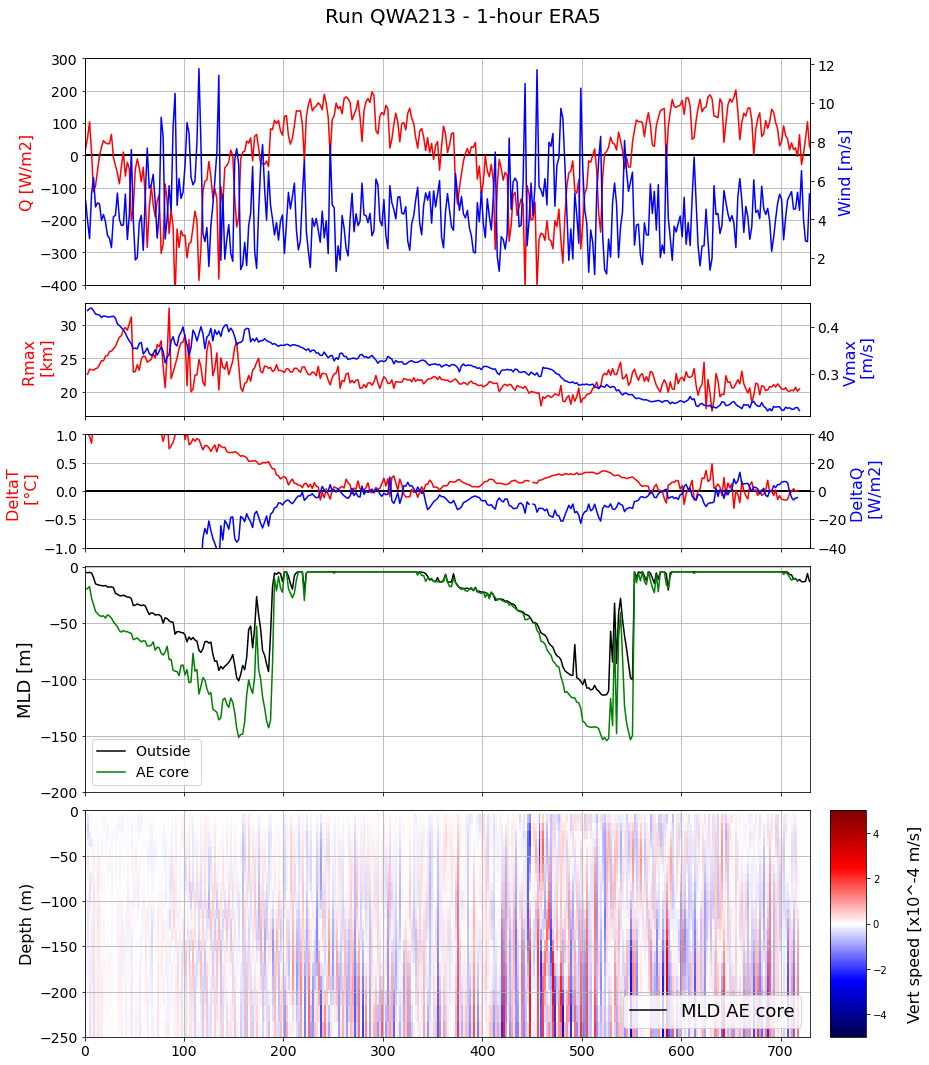

In [55]:
plt.figure(0, figsize=(14,18)) ; LS=14 ; dTmax=1
id20 =np.argmin(np.abs(zvert+20)) ; id50 =np.argmin(np.abs(zvert+50))

gs = GridSpec(5, 2, width_ratios=[20,1], height_ratios=[2,1,1,2,2], wspace=0.05, hspace=0.1)

ax0= plt.subplot(gs[1,0])                                  ###### RMAX
plt.plot(timeeddy,Rmaxed,'-r')
#for h in MainEddy:
#    plt.plot(D[tracks['step'][h,0]][0]*timestep, D[tracks['rmax1'][h,0]][0],'-r')
plt.grid() ; plt.ylabel('Rmax \n [km]', size=16, color='r') ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.xlim([0,2*365])
          
ax1=ax0.twinx(); plt.tick_params(labelbottom=False, labelsize=LS)  ###### VMAX
plt.plot(timeeddy,Vmaxed,'-b')
#for h in MainEddy:
#    ax1.plot(D[tracks['step'][h,0]][0]*timestep, D[tracks['velmax1'][h,0]][0],'-b')
plt.ylabel('Vmax \n [m/s]', size=16, color='b')
          
ax2 = plt.subplot(gs[0,0])                                     ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('Q [W/m2]',size=16, color='r')
plt.xlim([0,2*365]) ; plt.ylim([-400,300])

ax3=ax2.twinx() ; plt.tick_params(labelsize=LS)     #### Wind  
plt.plot(time, Wspeed,'-b') 
plt.ylabel('Wind [m/s]',size=16, color='b')

ax4 = plt.subplot(gs[2,0])                                      ### DeltaSST
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, DeltaT_h,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('DeltaT \n [\N{DEGREE SIGN}C]',size=16,color='r')
plt.yticks(np.arange(-2,3,0.5))
plt.xlim([0,2*365]) ; plt.ylim([-dTmax,dTmax])

ax5=ax4.twinx() ; plt.tick_params(labelsize=LS)    ##### Delta Q
plt.plot(time, Qin-Qmean,'-b') 
plt.ylim([-40,40])
plt.ylabel('DeltaQ \n [W/m2]', size=16, color='b')

plt.subplot(gs[3,0])                                            ### MLD [t]
#plt.plot(time_h, nd.gaussian_filter1d(MLDout_h,sigma=1), '-k', label='Outside ')
#plt.plot(time_h, nd.gaussian_filter1d(MLDcore_h,sigma=1), '-c', label='AE core')
plt.plot(time, MLDout_h, '-k', label='Outside ')
#plt.plot(time, MLDcore_h, '--g', label='AE core')
plt.plot(time, MLDrmax_h, '-g', label='AE core')
plt.xlim([0,2*365]) ; plt.ylim([-200,1]) ; plt.grid()
plt.ylabel('MLD [m]', size=18) ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.legend(fontsize=LS)

plt.subplot(gs[4,0])    #### AKV/W inside
#CP1 = plt.pcolor(time, z_dzt, MixCore.T,cmap=cm.jet,vmin=1e-5, vmax=1e-1, norm=col.LogNorm()); plt.grid()
#CP2 = plt.contour(time, z_dzt, MixCore.T,colors=['k'],levels=np.arange(0.5,4,0.5))

CP1 = plt.pcolor(time_h, zvert, WEddy_h.T*1e4,cmap=cm.seismic,vmin=-5, vmax=5); plt.grid()
plt.plot(time, MLDcore, '-k', label='MLD AE core')
plt.xlim([0,365*2])
plt.ylabel('Depth (m)',size=16)  ; plt.legend(loc=4, fontsize=18)
plt.ylim([-250,0])  ; plt.tick_params(labelsize=LS)
CB=plt.colorbar(CP1,cax=plt.subplot(gs[4:,1]))
CB.ax.set_ylabel('Vert speed [x10^-4 m/s]', fontsize=16, labelpad=20)

plt.suptitle(str_title, y=0.92,size=20)

path_save='../Analysis/'
#plt.savefig(path_save+str_title[4:9]+'_HIS_W_MLD_evol.png')

In [53]:
id20 =np.argmin(np.abs(zvert+20)) ; id50 =np.argmin(np.abs(zvert+50))
zvert[id50:]

masked_array(data=[-48.78824996948242, -45.082794189453125,
                   -41.39490509033203, -37.72355651855469,
                   -34.067840576171875, -30.42696189880371,
                   -26.800193786621094, -23.186914443969727,
                   -19.58658790588379, -15.998763084411621,
                   -12.42306137084961, -8.859190940856934,
                   -5.306929111480713, -1.7661278247833252],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False],
       fill_value=1e+20,
            dtype=float32)

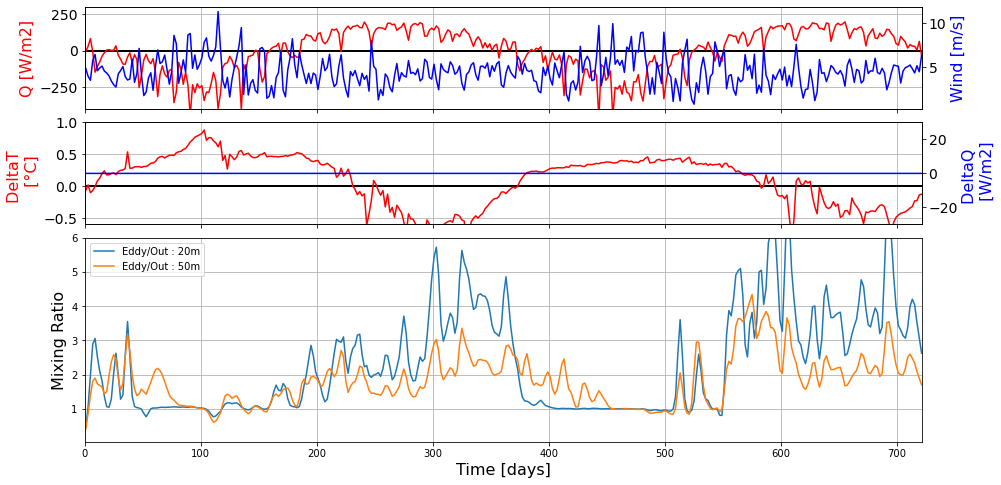

In [55]:
plt.figure(0, figsize=(15,8))  ; t0=0 ; tF=time[-1]
gs = GridSpec(3, 1, height_ratios=[1,1,2], wspace=0.05, hspace=0.1)

ax2 = plt.subplot(gs[0])                                     ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('Q [W/m2]',size=16, color='r') ; plt.xlim([t0,tF]) ; plt.ylim([-400,300])
ax3=ax2.twinx() ; plt.tick_params(labelsize=LS)                #### Wind  
plt.plot(time, Wspeed,'-b') ; plt.ylabel('Wind [m/s]',size=16, color='b')

ax4 = plt.subplot(gs[1])                                      ### DeltaSST
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time_h, DeltaT_h,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('DeltaT \n [\N{DEGREE SIGN}C]',size=16,color='r')
plt.yticks(np.arange(-0.5,1.5,0.5)) ;plt.xlim([t0,tF]) ; plt.ylim([-0.6,1])
ax5=ax4.twinx() ; plt.tick_params(labelsize=LS)              ##### Delta Q
plt.plot(time, Qin-Qmean,'-b') ;plt.ylim([-30,30]) ; plt.ylabel('DeltaQ \n [W/m2]', size=16, color='b')

#### Mixing ratio 
plt.subplot(gs[2]) 
#plt.plot(time_h[:],nd.gaussian_filter1d(np.average(MixCore_h[:,-20:]/MixOut_h[:,-20:],axis=1),sigma=1), label='Core/Out')
plt.plot(time_h[:],nd.gaussian_filter1d(np.average(MixEddy_h[:,id20:]/MixOut_h[:,id20:],axis=1),sigma=1), label='Eddy/Out : 20m')
plt.plot(time_h[:],nd.gaussian_filter1d(np.average(MixEddy_h[:,id50:]/MixOut_h[:,id50:],axis=1),sigma=1), label='Eddy/Out : 50m')
#plt.plot(time_h[:],np.average(MixCore_h[:,-20:]/MixOut_h[:,-20:],axis=1), label='Core/Out')
#plt.plot(time_h[:],np.average(MixEddy_h[:,-20:]/MixOut_h[:,-20:],axis=1), label='Eddy/Out')

plt.legend() ; plt.ylim([3e-2,6]) ; plt.xlim([t0,tF])

plt.ylabel('Mixing  Ratio',size=16) ; plt.xlabel('Time [days]', size=16) 
#plt.plot(time_h[:100],np.median(MixOut_h[:100,-20:],axis=1))
#plt.yscale('log') ; 
plt.grid()
#plt.savefig(path_save+str_title[4:9]+'_MixingRatio.png')

<ipython-input-33-e7c613157d2f>:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  CP1 = plt.pcolor(time_h, zvert, MixEddy_h.T/MixOut_h.T,cmap=cm.bwr,norm=col.LogNorm(),vmin=1e-1, vmax=1e1); plt.grid()


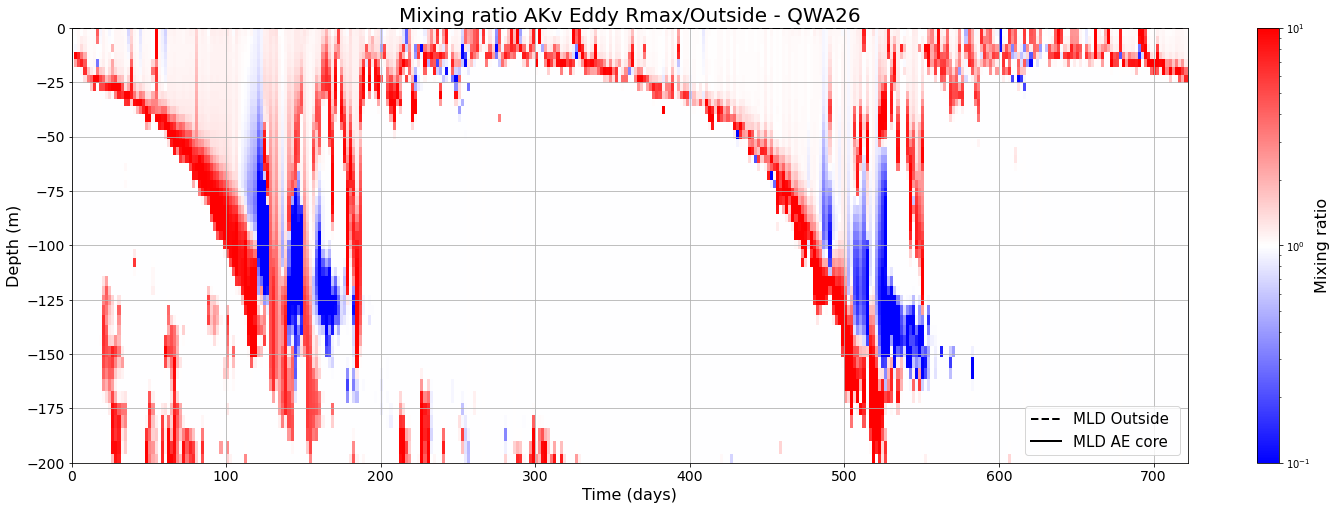

In [33]:
plt.figure(0, figsize=(25,8))
#CP1 = plt.pcolor(time, zvert, np.log10(MixEddy.T/MixOut.T),cmap=cm.bwr,vmin=-3, vmax=3); plt.grid()
CP1 = plt.pcolor(time_h, zvert, MixEddy_h.T/MixOut_h.T,cmap=cm.bwr,norm=col.LogNorm(),vmin=1e-1, vmax=1e1); plt.grid()
#CP1 = plt.pcolor(time_h, z_dzt[1:], MixCore_h[:,1:].T/MixOut_h.T,cmap=cm.bwr,norm=col.LogNorm(),vmin=10**(-1), vmax=10**(1)); plt.grid()
plt.plot(time, MLDout, '--k', lw=2, label='MLD Outside ')
plt.plot(time, MLDcore, '-k', lw=2, label='MLD AE core')
plt.legend(loc=4,fontsize=15) 

plt.ylabel('Depth (m)',size=16)
plt.xlabel('Time (days)', size=16) ; plt.ylim([-350,0])
CB=plt.colorbar()#cax=plt.subplot(gs[4,1]))
CB.ax.set_ylabel('Mixing ratio', fontsize=16)

plt.ylabel('Depth (m)',size=16) 
plt.xlabel('Time (days)', size=16) ; plt.ylim([-200,0]) ; plt.tick_params( labelsize=LS)
plt.title('Mixing ratio AKv Eddy Rmax/Outside - '+str_title[4:9],size=20)
path_save='../Analysis/'
plt.savefig(path_save+str_title[4:9]+'_MixingRatio_vert.png')

## Mixing ratio sensibility

<ipython-input-42-e4ccc452fbcc>:1: RuntimeWarning: invalid value encountered in true_divide
  MixRatio=np.average(MixEddy_h[:,-20:]/MixOut_h[:,-20:],axis=1)


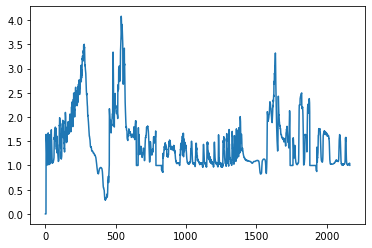

In [42]:
MixRatio=np.average(MixEddy_h[:,-20:]/MixOut_h[:,-20:],axis=1)
plt.plot(MixRatio)

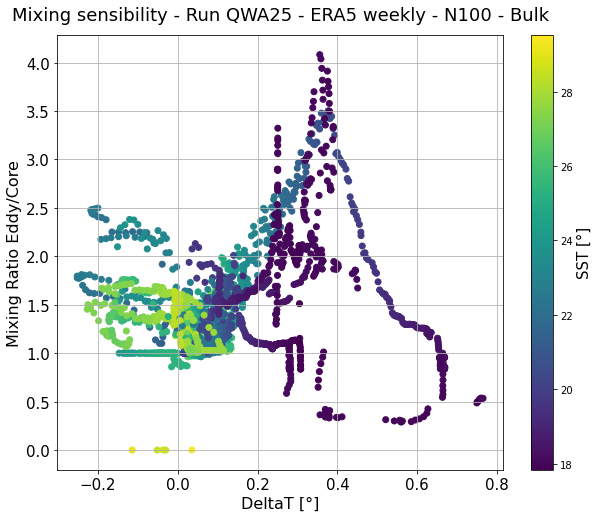

In [43]:
plt.figure(0, figsize=(10,8))

plt.scatter(DeltaT_h,MixRatio, c=SSTout_h)
#plt.yscale('log')
plt.grid() ; CB = plt.colorbar()
CB.set_label('SST [\N{DEGREE SIGN}]', size=15)
plt.xlabel('DeltaT [\N{DEGREE SIGN}]', size=16)
plt.ylabel('Mixing Ratio Eddy/Core', size=16)

plt.tick_params(labelsize=15) #;plt.legend(fontsize=15)
plt.title('Mixing sensibility - '+str_title,size=18, y=1.02)
plt.savefig(path_save+str_title[4:9]+'_Mixing_DeltaT.png')